<a id="import"></a>
# <center>Import Need Modules</center>

In [ ]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


<a id="makedf"></a>
# <center>read in train and test files and create train_test, valid dataframes</center>

In [ ]:
import gdown
!gdown --fuzzy https://drive.google.com/file/d/1_zfD7QQfQZNF4-aheS9KabVX7ZnuxHZU/view?usp=sharing
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-105.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-106.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-107.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-108.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-109.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-110.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-111.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-112.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-113.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-114.jpg  
  inflating: train/Seborrheic Keratoses and other

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1KTvAtLVgRSBafCvK82ahhqfOMp2vX3n4/view?usp=drive_link
!unzip test.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KTvAtLVgRSBafCvK82ahhqfOMp2vX3n4
From (redirected): https://drive.google.com/uc?id=1KTvAtLVgRSBafCvK82ahhqfOMp2vX3n4&confirm=t&uuid=e3d4dd7f-df9f-40e4-bcc7-c59bc446aa03
To: /content/test.zip
100% 376M/376M [00:05<00:00, 74.5MB/s]
Archive:  test.zip
   creating: test/Acne and Rosacea Photos/
  inflating: test/Acne and Rosacea Photos/07PerioralDermEye.jpg  
  inflating: test/Acne and Rosacea Photos/07Rhinophyma1.jpg  
  inflating: test/Acne and Rosacea Photos/07rhnophymas0321051.jpg  
  inflating: test/Acne and Rosacea Photos/07RosaceaFulFAce.jpg  
  inflating: test/Acne and Rosacea Photos/07RosaceaMilia0120.jpg  
  inflating: test/Acne and Rosacea Photos/07RosaceaOK0828063.jpg  
  inflating: test/Acne and Rosacea Photos/07sebDerem1101051.jpg  
  inflating: test/Acne and Rosacea Photos/07SteroidPerioral.jpg  
  inflating: test/Acne and Rosacea Photos/07SteroidPerioral1.jpg  
  inflating: test/Acne and Rosacea Photos/07Vascul

In [ ]:
def make_dataframes(train_dir,test_dir):
    dirlist=[train_dir, test_dir]
    names=['train','test']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )
        for klass in classlist:
            sklass=klass[:25] # use only first 25 characters of the class as some are very long
            classpath=os.path.join(d, klass)
            flist=sorted(os.listdir(classpath))
            desc=f'{name:6s}-{sklass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(sklass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if name =='test':
            test_df=df
        else:
            pdf=df
    # create a train_df and a valid_df
    train_df, valid_df = train_test_split(pdf, train_size=.9, shuffle=True, random_state = 123, stratify = pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)
    counts=list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count

train_dir = "/content/train"
test_dir= "/content/test"
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir, test_dir)

test  -Warts Molluscum and other: 100%|██████████████████████████████████████████████████| 272/272 [00:00<00:00, 334168.33files/s]


number of classes in processed dataset=  23
the maximum files in any class in train_df is  1264   the minimum files in any class in train_df is  191
train_df length:  14001   test_df length:  4002   valid_df length:  1556
average image height=  529   average image width=  672  aspect ratio h/w=  0.7872023809523809


<a id="trim"></a>
## <center>Trim train_df so no class has more than 300 images </center>

In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=300  # LIMIT MAXIMUM IMAGE SAMPLES IN ANY CLASS TO 160 IMAGES TO HELP BALANCE THE DATASET
min_samples=191
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  14001  with  23  classes
after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  191
the trimmed dataframe now is of length  6599  with  23  classes


<a id="balance"></a>
## <center>Expand train_df rows with augmented images so each class has 300 samples</center>
### This will fully balance train_df to have 300 image samples per class


In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=300
working_dir=r'./'
img_size = (224, 260) # img size will significantly impact training time
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  6599
Found 234 validated image filenames.
Found 259 validated image filenames.
Found 215 validated image filenames.
Found 191 validated image filenames.
Total Augmented images created=  301
Length of augmented dataframe is now  6900


<a id="generators"></a>
# <center>Create the train_gen, test_gen and valid_gen</center>

In [ ]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size, use_scientific=False):
    ycol='labels'
    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol , target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=30
use_scientific=False # if set to true will use scientific labels, otherwise use common name labels
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size,use_scientific=use_scientific)


Found 6900 validated image filenames belonging to 23 classes.
Found 1556 validated image filenames belonging to 23 classes.
Found 4002 validated image filenames belonging to 23 classes.
test batch size:  69   test steps:  58  number of classes :  23


<a id="show"></a>
# <center>Create a function to show example training images</center>

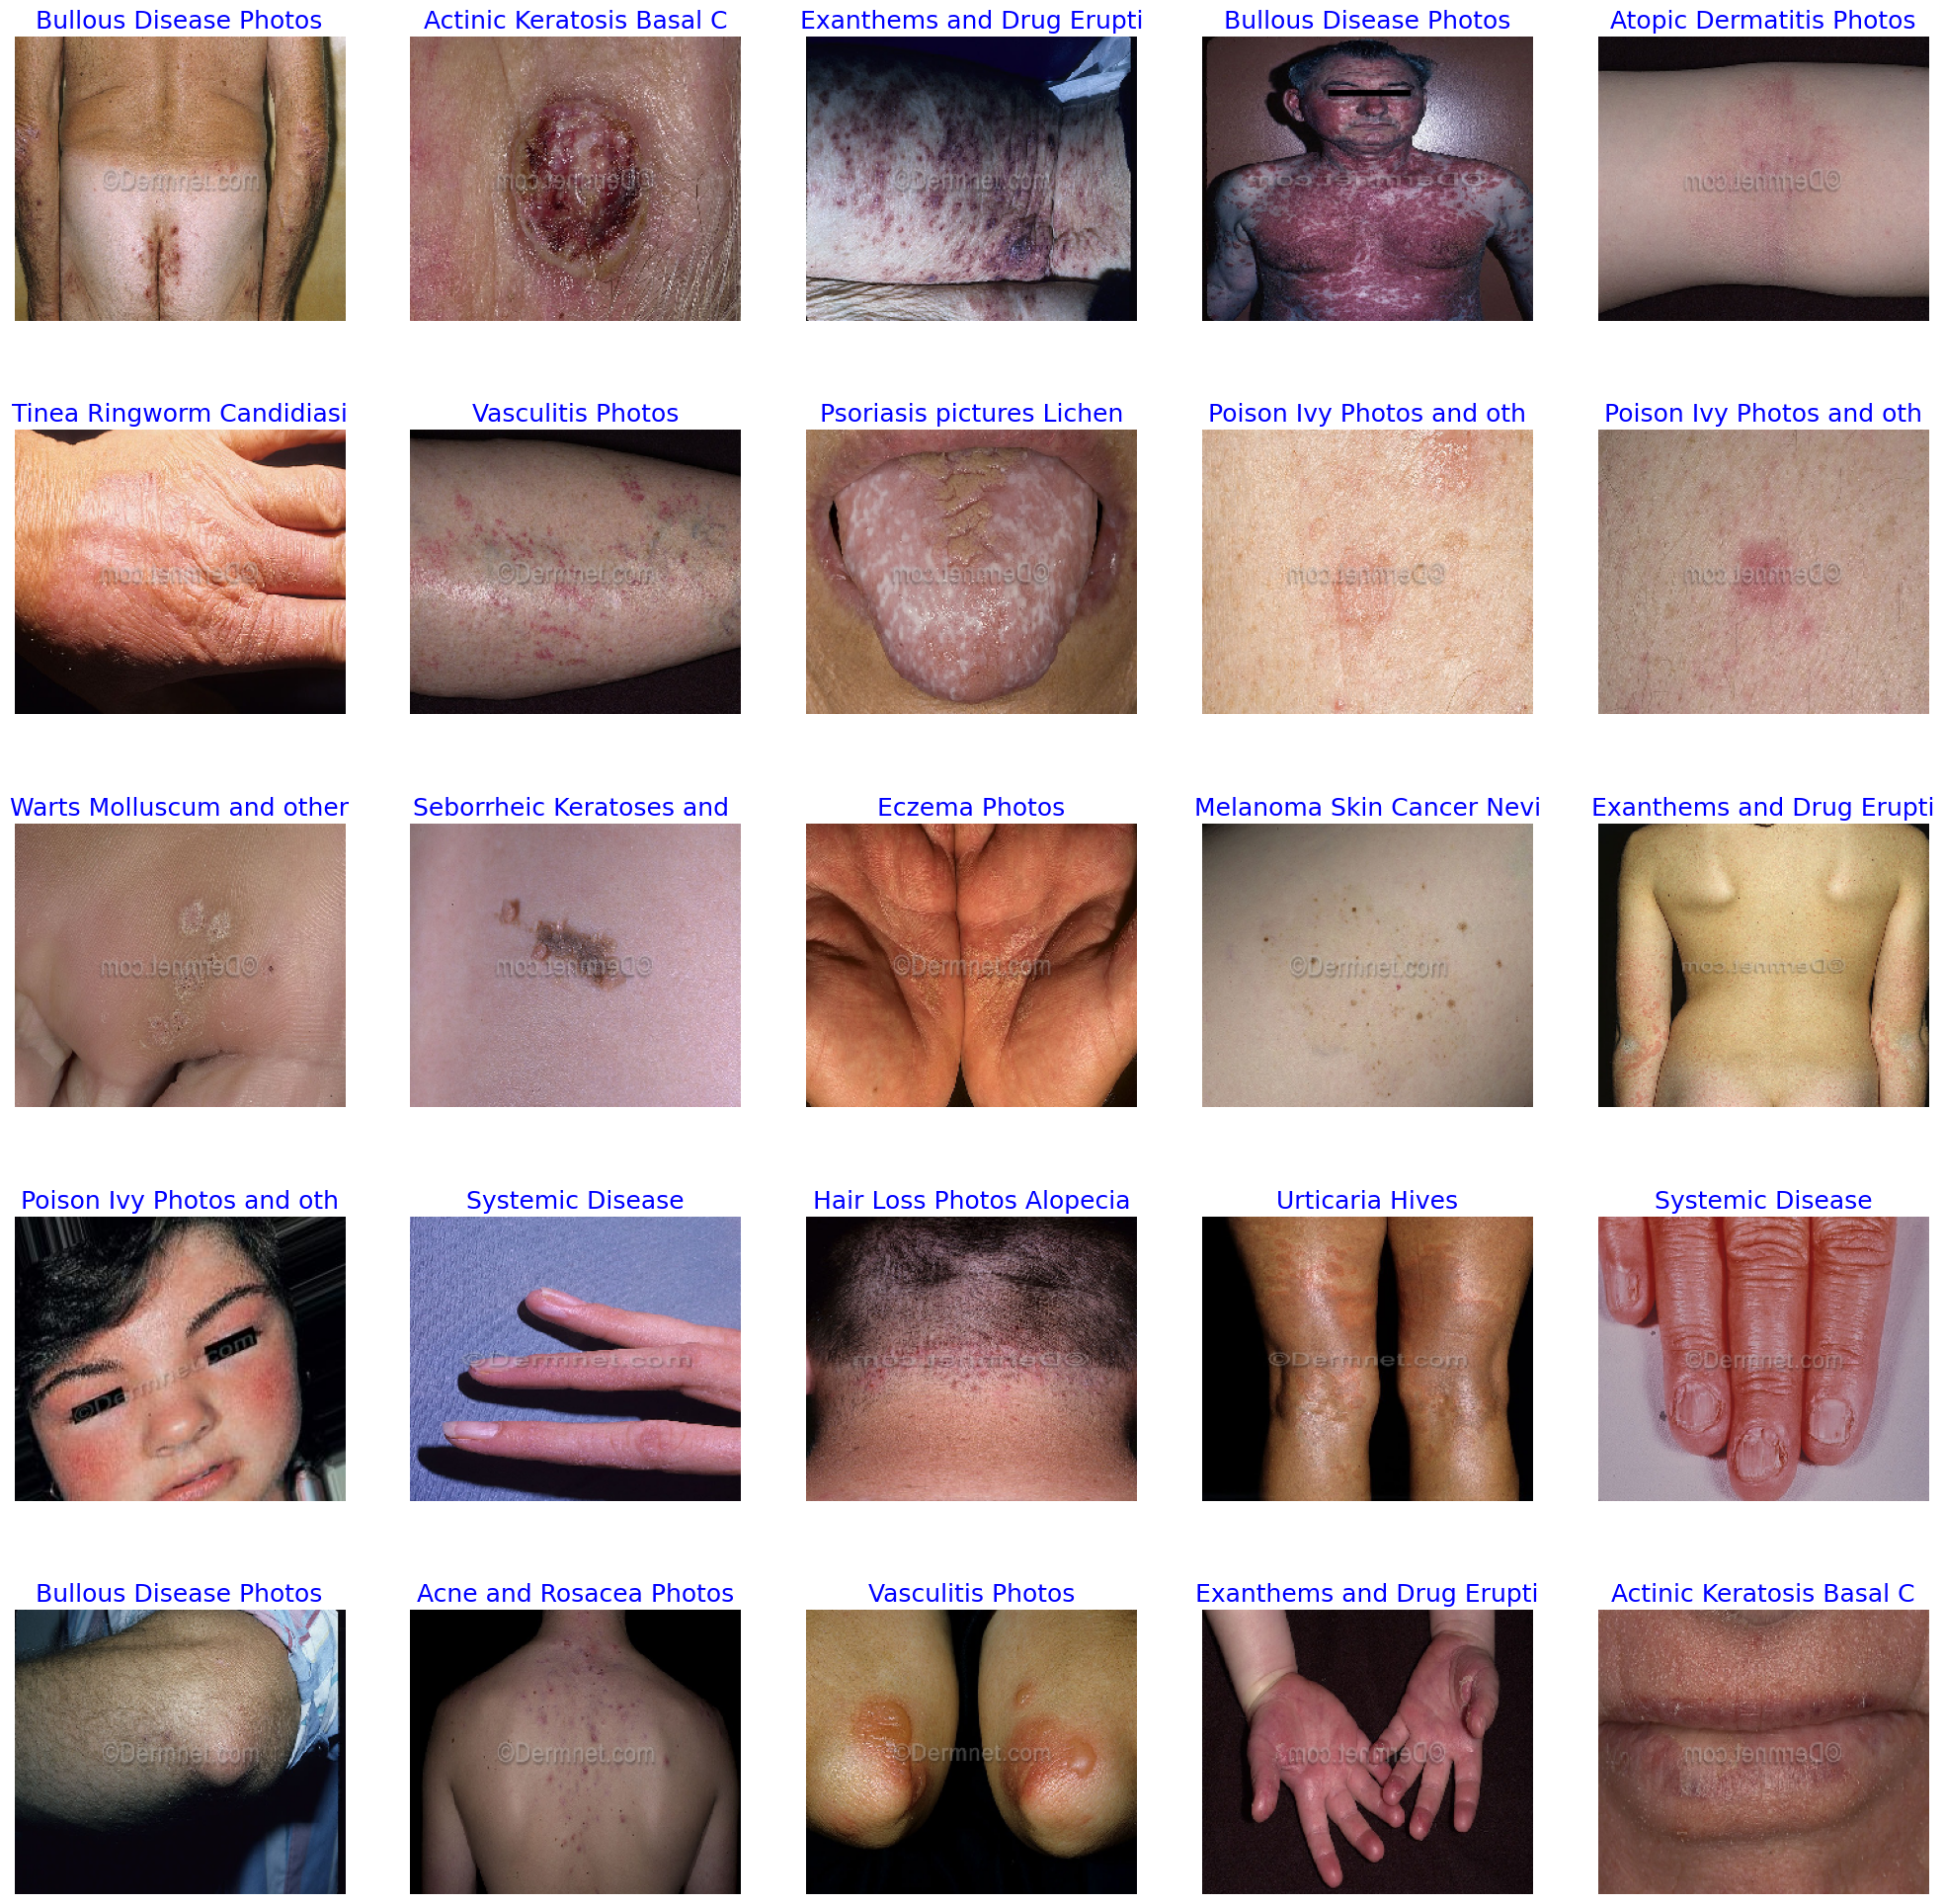

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>

In [ ]:


    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B3 model'

    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

43941136/43941136 [==============================] - 2s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



<a id="callbacks"></a>
# <center>Instantiate callback</center>

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
epochs=40
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_acc', mode='max')


<a id="train"></a>
# <center>Train the model</center>

In [ ]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=[early_stopping, reduce_lr, model_checkpoint],  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/40
230/230 [==============================] - ETA: 0s - loss: 9.4072 - accuracy: 0.1613

230/230 [==============================] - 200s 625ms/step - loss: 9.4072 - accuracy: 0.1613 - val_loss: 7.7439 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 2/40
230/230 [==============================] - ETA: 0s - loss: 6.7930 - accuracy: 0.2991

230/230 [==============================] - 135s 588ms/step - loss: 6.7930 - accuracy: 0.2991 - val_loss: 6.0071 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 3/40
230/230 [==============================] - ETA: 0s - loss: 5.1880 - accuracy: 0.4136

230/230 [==============================] - 136s 590ms/step - loss: 5.1880 - accuracy: 0.4136 - val_loss: 4.8410 - val_accuracy: 0.3599 - lr: 0.0010
Epoch 4/40
230/230 [==============================] - ETA: 0s - loss: 3.9413 - accuracy: 0.5219

230/230 [==============================] - 136s 590ms/step - loss: 3.9413 - accuracy: 0.5219 - val_loss: 3.9776 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 5/40
230/230 [==============================] - ETA: 0s - loss: 2.9738 - accuracy: 0.6361

230/230 [==============================] - 139s 602ms/step - loss: 2.9738 - accuracy: 0.6361 - val_loss: 3.5017 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 6/40
230/230 [==============================] - ETA: 0s - loss: 2.2480 - accuracy: 0.7252

230/230 [==============================] - 136s 589ms/step - loss: 2.2480 - accuracy: 0.7252 - val_loss: 3.1084 - val_accuracy: 0.4434 - lr: 0.0010
Epoch 7/40
230/230 [==============================] - ETA: 0s - loss: 1.7108 - accuracy: 0.8086

230/230 [==============================] - 135s 588ms/step - loss: 1.7108 - accuracy: 0.8086 - val_loss: 2.9021 - val_accuracy: 0.4518 - lr: 0.0010
Epoch 8/40
230/230 [==============================] - ETA: 0s - loss: 1.3329 - accuracy: 0.8699

230/230 [==============================] - 135s 587ms/step - loss: 1.3329 - accuracy: 0.8699 - val_loss: 2.8535 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 9/40
230/230 [==============================] - ETA: 0s - loss: 1.0739 - accuracy: 0.9078

230/230 [==============================] - 135s 588ms/step - loss: 1.0739 - accuracy: 0.9078 - val_loss: 2.7196 - val_accuracy: 0.4492 - lr: 0.0010
Epoch 10/40
230/230 [==============================] - ETA: 0s - loss: 0.9120 - accuracy: 0.9270

230/230 [==============================] - 135s 587ms/step - loss: 0.9120 - accuracy: 0.9270 - val_loss: 2.6219 - val_accuracy: 0.4666 - lr: 0.0010
Epoch 11/40
230/230 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.9454

230/230 [==============================] - 139s 603ms/step - loss: 0.7931 - accuracy: 0.9454 - val_loss: 2.5248 - val_accuracy: 0.4781 - lr: 0.0010
Epoch 12/40
230/230 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.9555

230/230 [==============================] - 135s 588ms/step - loss: 0.6928 - accuracy: 0.9555 - val_loss: 2.3854 - val_accuracy: 0.4859 - lr: 0.0010
Epoch 13/40
230/230 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.9614

230/230 [==============================] - 136s 589ms/step - loss: 0.6323 - accuracy: 0.9614 - val_loss: 2.4753 - val_accuracy: 0.4692 - lr: 0.0010
Epoch 14/40
230/230 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.9638

230/230 [==============================] - 136s 589ms/step - loss: 0.5837 - accuracy: 0.9638 - val_loss: 2.4454 - val_accuracy: 0.4801 - lr: 0.0010
Epoch 15/40
230/230 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.9686

230/230 [==============================] - 136s 589ms/step - loss: 0.5389 - accuracy: 0.9686 - val_loss: 2.4390 - val_accuracy: 0.4814 - lr: 0.0010
Epoch 16/40
230/230 [==============================] - ETA: 0s - loss: 0.5146 - accuracy: 0.9657

230/230 [==============================] - 135s 589ms/step - loss: 0.5146 - accuracy: 0.9657 - val_loss: 2.3766 - val_accuracy: 0.4801 - lr: 0.0010
Epoch 17/40
230/230 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.9764

230/230 [==============================] - 136s 590ms/step - loss: 0.4752 - accuracy: 0.9764 - val_loss: 2.4274 - val_accuracy: 0.4878 - lr: 0.0010
Epoch 18/40
230/230 [==============================] - ETA: 0s - loss: 0.4349 - accuracy: 0.9810

230/230 [==============================] - 136s 589ms/step - loss: 0.4349 - accuracy: 0.9810 - val_loss: 2.4113 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 19/40
230/230 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.9757

230/230 [==============================] - 136s 589ms/step - loss: 0.4311 - accuracy: 0.9757 - val_loss: 2.4522 - val_accuracy: 0.4814 - lr: 0.0010
Epoch 20/40
230/230 [==============================] - ETA: 0s - loss: 0.4197 - accuracy: 0.9770

230/230 [==============================] - 136s 589ms/step - loss: 0.4197 - accuracy: 0.9770 - val_loss: 2.4608 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 21/40
230/230 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.9783

230/230 [==============================] - 135s 588ms/step - loss: 0.4028 - accuracy: 0.9783 - val_loss: 2.4405 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 22/40
230/230 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.9854

230/230 [==============================] - 136s 591ms/step - loss: 0.3603 - accuracy: 0.9854 - val_loss: 2.3145 - val_accuracy: 0.5116 - lr: 1.0000e-04
Epoch 23/40
230/230 [==============================] - ETA: 0s - loss: 0.3436 - accuracy: 0.9878

230/230 [==============================] - 136s 591ms/step - loss: 0.3436 - accuracy: 0.9878 - val_loss: 2.2885 - val_accuracy: 0.5116 - lr: 1.0000e-04
Epoch 24/40
230/230 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.9897

230/230 [==============================] - 136s 591ms/step - loss: 0.3269 - accuracy: 0.9897 - val_loss: 2.2589 - val_accuracy: 0.5180 - lr: 1.0000e-04
Epoch 25/40
230/230 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.9890

230/230 [==============================] - 135s 588ms/step - loss: 0.3196 - accuracy: 0.9890 - val_loss: 2.2438 - val_accuracy: 0.5212 - lr: 1.0000e-04
Epoch 26/40
230/230 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.9884

230/230 [==============================] - 136s 589ms/step - loss: 0.3171 - accuracy: 0.9884 - val_loss: 2.2348 - val_accuracy: 0.5148 - lr: 1.0000e-04
Epoch 27/40
230/230 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.9899

230/230 [==============================] - 136s 590ms/step - loss: 0.3072 - accuracy: 0.9899 - val_loss: 2.2251 - val_accuracy: 0.5161 - lr: 1.0000e-04
Epoch 28/40
230/230 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.9897

230/230 [==============================] - 136s 589ms/step - loss: 0.3033 - accuracy: 0.9897 - val_loss: 2.2154 - val_accuracy: 0.5180 - lr: 1.0000e-04
Epoch 29/40
230/230 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.9897

230/230 [==============================] - 139s 602ms/step - loss: 0.3007 - accuracy: 0.9897 - val_loss: 2.2060 - val_accuracy: 0.5225 - lr: 1.0000e-04
Epoch 30/40
230/230 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.9888

230/230 [==============================] - 136s 589ms/step - loss: 0.2959 - accuracy: 0.9888 - val_loss: 2.2144 - val_accuracy: 0.5154 - lr: 1.0000e-04
Epoch 31/40
230/230 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.9904

230/230 [==============================] - 135s 588ms/step - loss: 0.2890 - accuracy: 0.9904 - val_loss: 2.2096 - val_accuracy: 0.5167 - lr: 1.0000e-04
Epoch 32/40
230/230 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.9886

230/230 [==============================] - 136s 590ms/step - loss: 0.2885 - accuracy: 0.9886 - val_loss: 2.1969 - val_accuracy: 0.5154 - lr: 1.0000e-04
Epoch 33/40
230/230 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9914

230/230 [==============================] - 135s 589ms/step - loss: 0.2798 - accuracy: 0.9914 - val_loss: 2.1868 - val_accuracy: 0.5174 - lr: 1.0000e-04
Epoch 34/40
230/230 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.9920

230/230 [==============================] - 136s 589ms/step - loss: 0.2750 - accuracy: 0.9920 - val_loss: 2.1772 - val_accuracy: 0.5193 - lr: 1.0000e-04
Epoch 35/40
230/230 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.9928

230/230 [==============================] - 135s 588ms/step - loss: 0.2726 - accuracy: 0.9928 - val_loss: 2.1872 - val_accuracy: 0.5148 - lr: 1.0000e-04
Epoch 36/40
230/230 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9917

230/230 [==============================] - 136s 592ms/step - loss: 0.2733 - accuracy: 0.9917 - val_loss: 2.1885 - val_accuracy: 0.5180 - lr: 1.0000e-04
Epoch 37/40
230/230 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9910

230/230 [==============================] - 136s 590ms/step - loss: 0.2683 - accuracy: 0.9910 - val_loss: 2.1832 - val_accuracy: 0.5199 - lr: 1.0000e-04
Epoch 38/40
230/230 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.9910

230/230 [==============================] - 136s 591ms/step - loss: 0.2674 - accuracy: 0.9910 - val_loss: 2.1849 - val_accuracy: 0.5174 - lr: 1.0000e-04
Epoch 39/40
230/230 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9917

230/230 [==============================] - 135s 589ms/step - loss: 0.2632 - accuracy: 0.9917 - val_loss: 2.1775 - val_accuracy: 0.5135 - lr: 1.0000e-04
Epoch 40/40
230/230 [==============================] - ETA: 0s - loss: 0.2611 - accuracy: 0.9909

230/230 [==============================] - 136s 591ms/step - loss: 0.2611 - accuracy: 0.9909 - val_loss: 2.1711 - val_accuracy: 0.5186 - lr: 1.0000e-04


<a id="plot"></a>
# <center>Define a function to plot the training data</center>

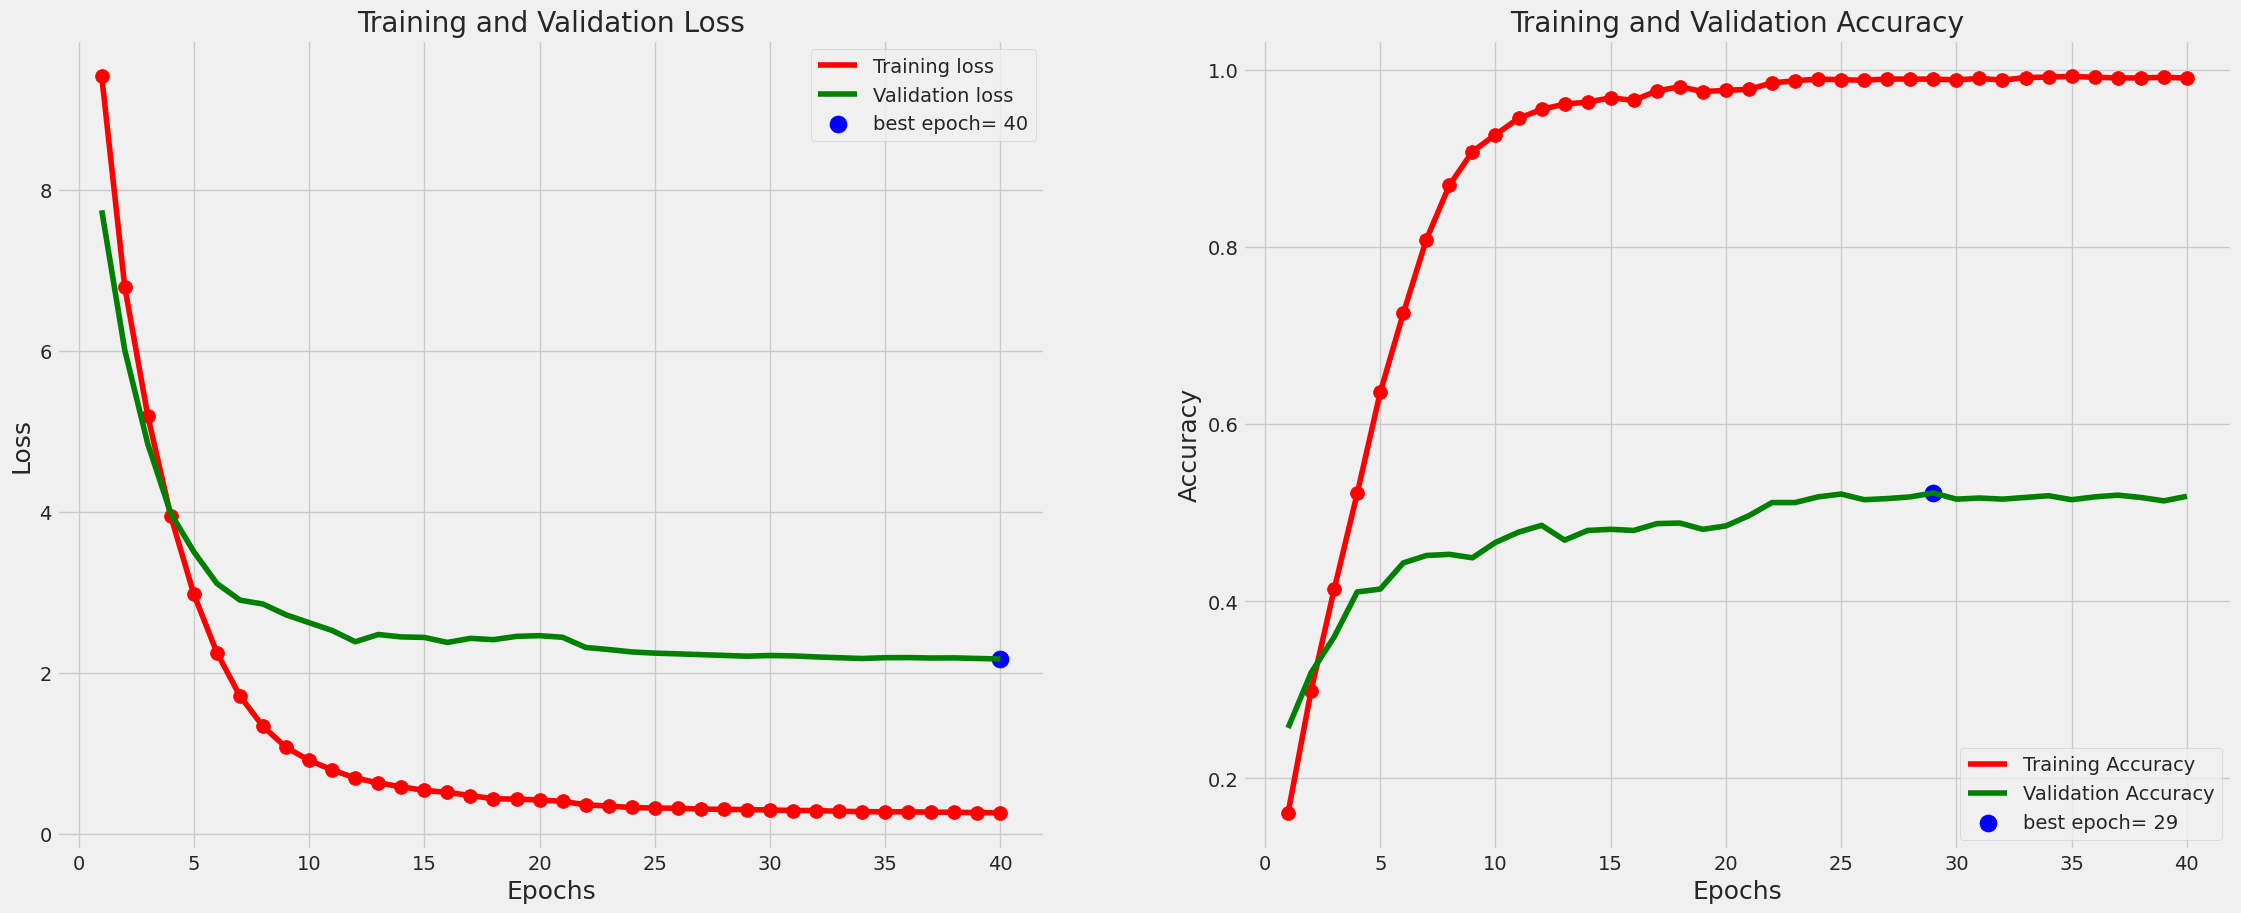

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout
    plt.show()
    return index_loss

loss_index=tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a></center>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

58/58 [==============================] - 27s 347ms/step
there were 1881 errors in 4002 tests for an accuracy of  53.00



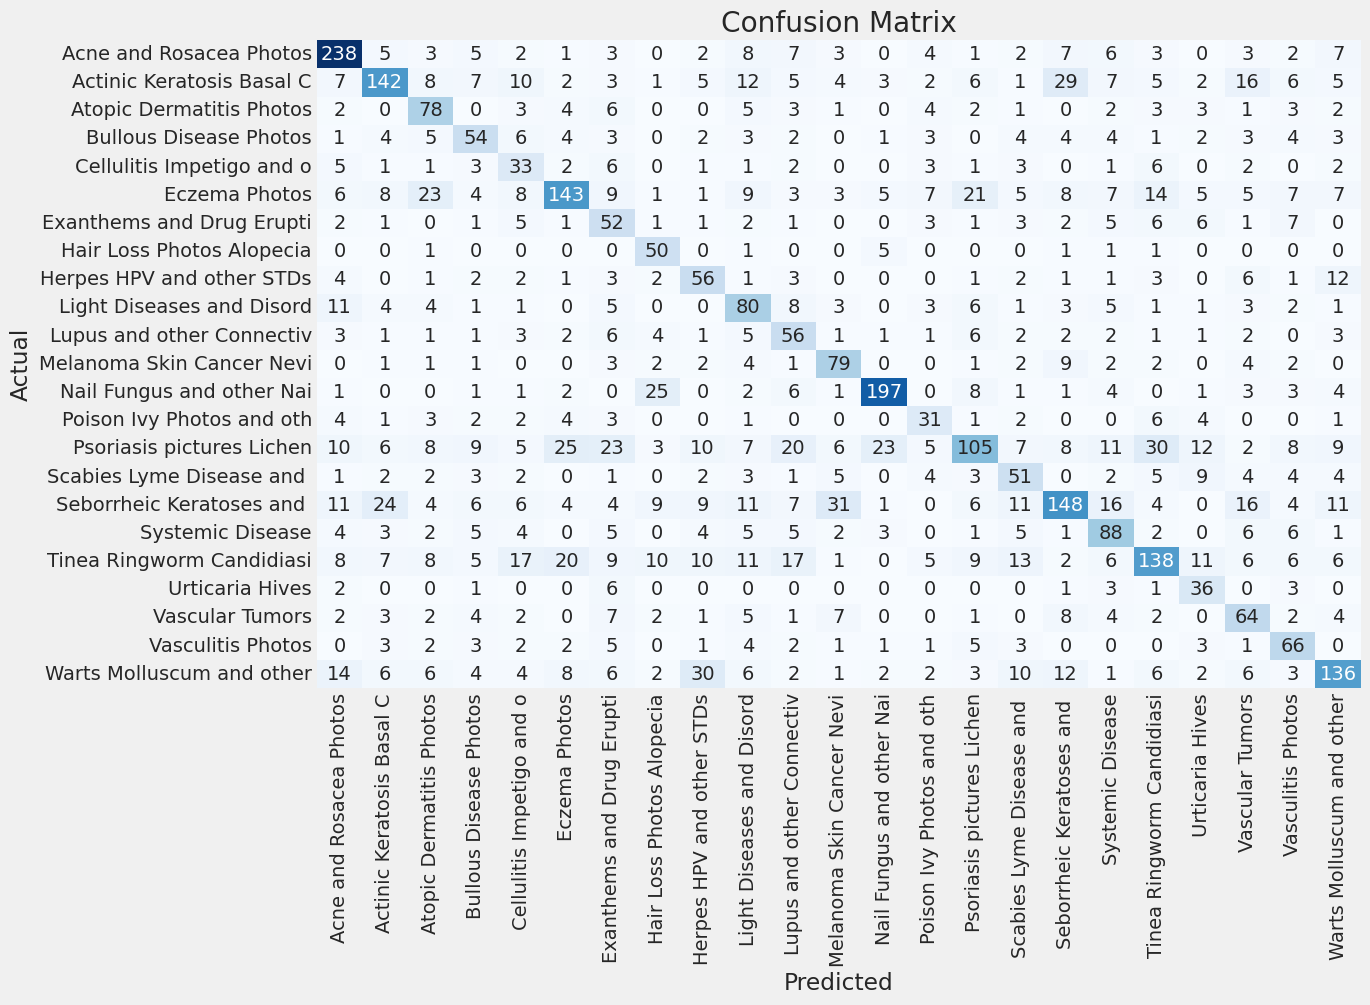

Classification Report:
----------------------
                            precision    recall  f1-score   support

  Acne and Rosacea Photos     0.7083    0.7628    0.7346       312
Actinic Keratosis Basal C     0.6396    0.4931    0.5569       288
 Atopic Dermatitis Photos     0.4785    0.6341    0.5455       123
   Bullous Disease Photos     0.4426    0.4779    0.4596       113
Cellulitis Impetigo and o     0.2797    0.4521    0.3455        73
            Eczema Photos     0.6356    0.4628    0.5356       309
Exanthems and Drug Erupti     0.3095    0.5149    0.3866       101
Hair Loss Photos Alopecia     0.4464    0.8333    0.5814        60
Herpes HPV and other STDs     0.4058    0.5490    0.4667       102
Light Diseases and Disord     0.4301    0.5594    0.4863       143
Lupus and other Connectiv     0.3684    0.5333    0.4358       105
Melanoma Skin Cancer Nevi     0.5302    0.6810    0.5962       116
Nail Fungus and other Nai     0.8140    0.7548    0.7833       261
Poison Ivy Pho

In [ ]:
def predictor(test_gen):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)